In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-07_10-14_20180601_20191231_base.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [32]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2018-06-01 12:50:30,GC,SELL,3.0,1301.30,1,ENTRY,7.26,0.00,80000.00
2018-06-01 14:38:30,GC,BUY,3.0,1296.90,2,STOP-LOSS,7.26,1305.48,81305.48
2018-06-01 15:35:30,NQ,BUY,0.1,7029.50,4,ENTRY,0.47,0.00,81305.48
2018-06-01 15:35:30,NQ,BUY,2.0,7029.50,3,ENTRY,4.20,0.00,81305.48
2018-06-01 16:16:30,NQ,SELL,2.0,7022.75,5,STOP-LOSS,4.20,-278.40,81027.08
...,...,...,...,...,...,...,...,...,...
2019-12-30 10:48:30,GC,SELL,24.0,1515.30,6620,STOP-LOSS,58.08,-8756.16,652928.10
2019-12-30 16:13:30,NQ,SELL,20.0,8707.25,6622,ENTRY,42.00,0.00,652817.28
2019-12-30 16:13:30,NQ,SELL,0.6,8707.25,6623,ENTRY,2.82,0.00,652817.28


In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       134669.44
GC        73567.80
NQ       213453.64
YM       151654.76
total    573345.64
Name: realizedPNL, dtype: float64

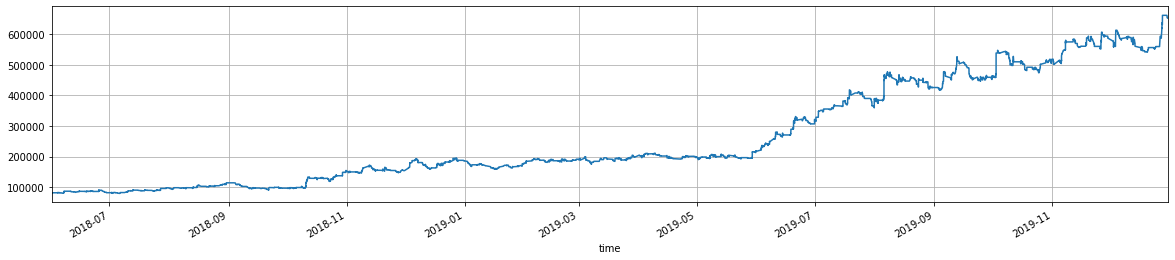

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

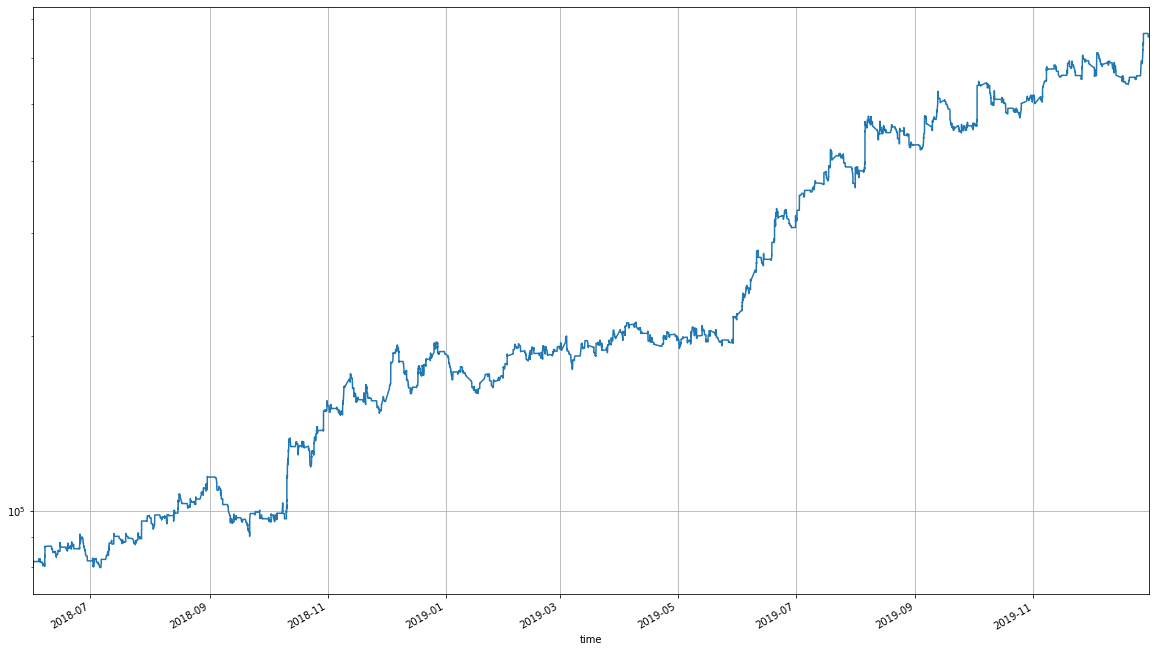

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,NQ,GC,YM,ES
time,,,,
2018-06-30,8.666667,3.714286,2.200000,1.333333
2018-07-31,5.363636,3.818182,1.454545,1.045455
2018-08-31,6.086957,4.000000,1.043478,0.826087
2018-09-30,7.600000,4.000000,1.000000,1.300000
2018-10-31,13.304348,4.000000,3.652174,3.043478
2018-11-30,12.000000,2.636364,2.363636,1.818182
2018-12-31,12.952381,3.142857,3.619048,3.142857
2019-01-31,8.173913,2.956522,2.434783,1.652174
2019-02-28,6.000000,2.250000,1.700000,1.000000


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     644
 GC    1578
 NQ    3526
 YM     864
 Name: action, dtype: int64, 6612)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.563107
 GC    3.830097
 NQ    8.558252
 YM    2.097087
 Name: action, dtype: float64, 16.04854368932039)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        4693.06
GC       18895.20
NQ       25247.36
YM        6394.24
total    55229.86
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        3.5
GC       25.7
NQ       11.8
YM        4.2
total     9.6
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.38,19.28,480.20,-261.98,1.83,20.05,4.73,789.0,3730.8
NQ,0.40,31.52,457.19,-255.50,1.79,29.58,3.14,1763.0,5530.4
YM,0.44,132.47,778.14,-379.25,2.05,130.00,3.24,432.0,1401.6
ES,0.46,141.16,988.31,-570.43,1.73,146.59,3.19,322.0,1025.9
total,0.41,52.47,565.77,-300.48,1.88,54.68,3.54,3306.0,11688.7


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC       0.198421
NQ       0.290000
YM       0.777273
ES       0.556087
total    0.440976
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.00,5221.92,2067.28,0.00,1822.30
2018-06-04,0.00,0.00,1061.76,0.00,265.44
2018-06-05,0.00,-4417.60,2824.64,-129.12,-430.52
2018-06-06,0.00,-3156.88,-1669.12,0.00,-1206.50
2018-06-07,12498.88,-4136.88,3302.88,14353.12,6504.50
...,...,...,...,...,...
2019-12-24,0.00,33662.16,0.00,0.00,8415.54
2019-12-25,0.00,0.00,0.00,0.00,0.00
2019-12-26,0.00,133785.68,0.00,0.00,33446.42


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.00000,0.016318,0.006460,0.000000,0.022779
2018-06-04,0.00000,0.000000,0.003244,0.000000,0.003244
2018-06-05,0.00000,-0.013454,0.008603,-0.000393,-0.005245
2018-06-06,0.00000,-0.009665,-0.005110,0.000000,-0.014775
2018-06-07,0.03884,-0.012855,0.010264,0.044602,0.080851
...,...,...,...,...,...
2019-12-24,0.00000,0.015268,0.000000,0.000000,0.015268
2019-12-25,0.00000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.00000,0.059768,0.000000,0.000000,0.059768


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

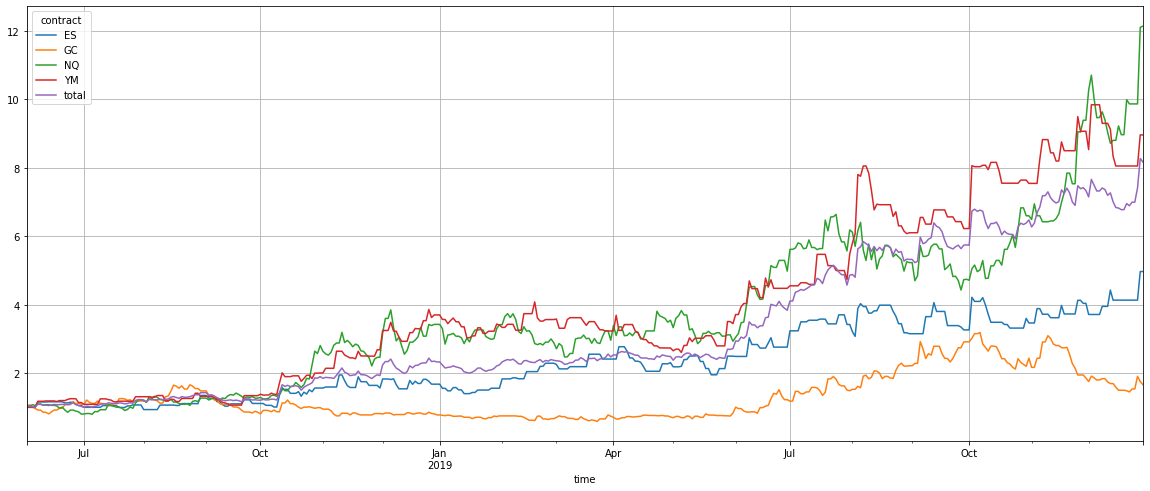

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.064524,0.201191,0.468108,0.644996
GC,-0.064524,1.000000,0.034401,0.006231,0.449145
NQ,0.201191,0.034401,1.000000,0.227782,0.621979
YM,0.468108,0.006231,0.227782,1.000000,0.675565
total,0.644996,0.449145,0.621979,0.675565,1.000000


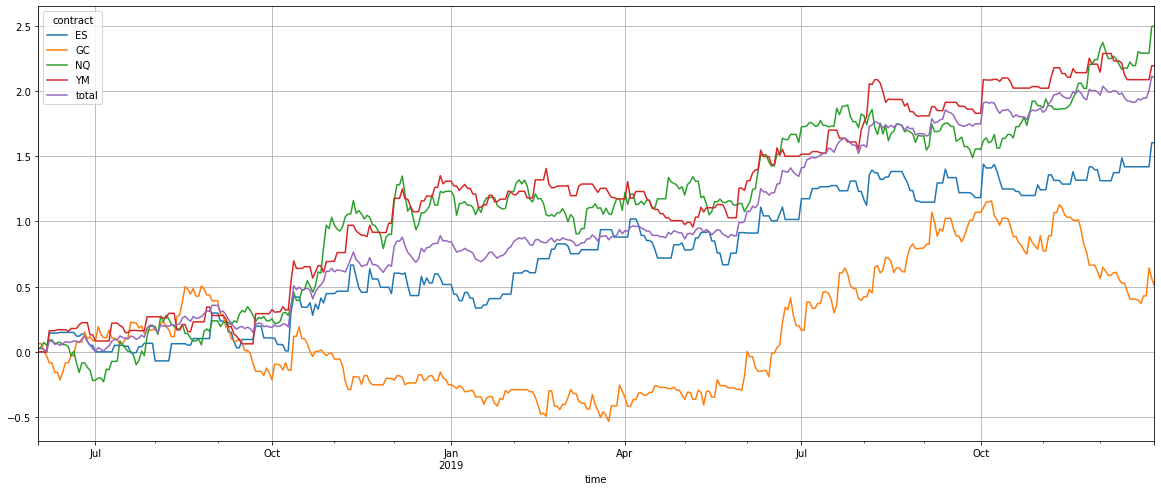

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

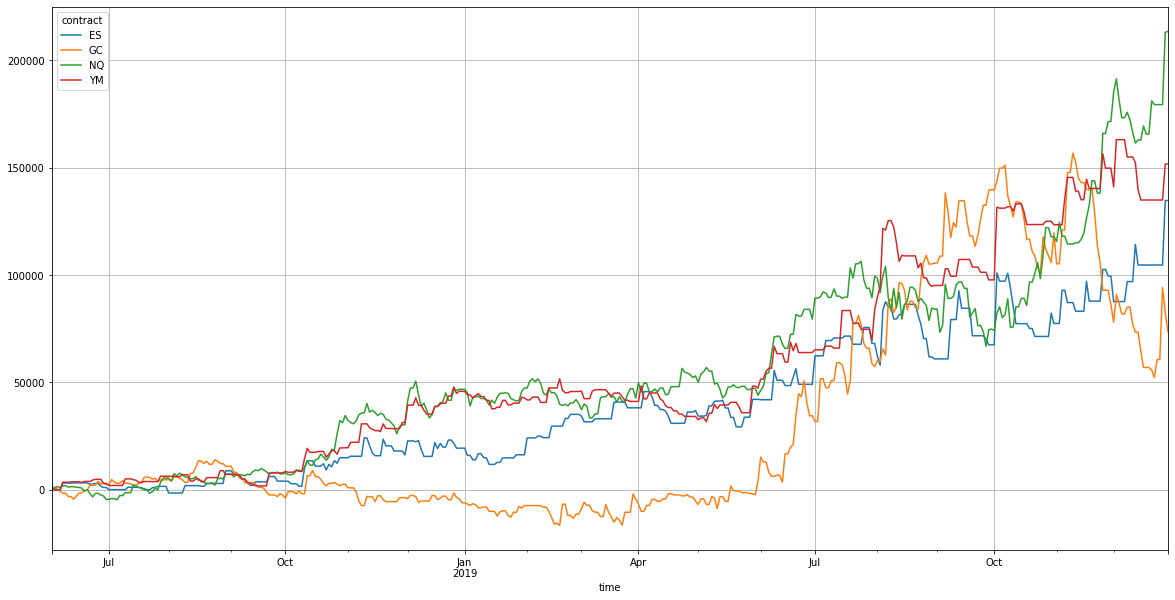

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.665848,0.363219,3.604637,2.824029,2.612914
Cumulative returns,3.968291,0.659603,11.141484,7.961401,7.166821
Annual volatility,0.875992,0.978325,0.932604,0.833595,0.542093
Sharpe ratio,1.526242,0.776255,2.091023,1.997735,2.634146
Calmar ratio,5.620307,0.562417,10.084500,7.798575,13.948591
Stability,0.934381,0.318919,0.904081,0.921192,0.958996
Max drawdown,-0.296398,-0.645818,-0.357443,-0.362121,-0.187325
Omega ratio,1.512709,1.167485,1.471997,1.701404,1.661459
Sortino ratio,3.268528,1.473059,3.803970,4.596589,5.822994
Skew,2.263117,1.636886,0.910668,2.376842,1.899557


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.364291,0.174060,0.584501,0.484114,2.612914
Cumulative returns,0.661736,0.299985,1.122307,0.906933,7.166821
Annual volatility,0.218998,0.244581,0.233151,0.208399,0.542093
Sharpe ratio,1.526242,0.776255,2.091023,1.997735,2.634146
Calmar ratio,4.622057,0.864045,6.245169,4.862996,13.948591
Stability,0.955572,0.511852,0.932415,0.936454,0.958996
Max drawdown,-0.078816,-0.201448,-0.093592,-0.099551,-0.187325
Omega ratio,1.512709,1.167485,1.471997,1.701404,1.661459
Sortino ratio,3.268528,1.473059,3.803970,4.596589,5.822994
Skew,2.263117,1.636886,0.910668,2.376842,1.899557


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.53,2.68,-5.01,3.70,2.55
2018-07-31,0.49,2.58,11.87,3.86,19.69
2018-08-31,6.74,6.44,1.58,0.66,16.41
2018-09-30,-4.28,-12.42,0.17,0.98,-15.28
2018-10-31,10.38,4.94,23.48,11.62,56.72
2018-11-30,0.99,-4.32,-2.67,8.26,1.58
2018-12-31,2.51,-1.01,10.40,9.18,20.68
2019-01-31,-1.61,-0.73,0.51,-1.80,-3.73
2019-02-28,10.58,-2.20,-3.74,1.61,6.00


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(12.700000000000001, 9.46)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2018-10-31    56.72
2019-06-30    41.22
2019-07-31    26.73
2018-12-31    20.68
2018-07-31    19.69
2018-08-31    16.41
2019-11-30    13.25
2019-10-31    12.70
2019-12-31    11.33
2019-08-31     9.46
2019-05-31     9.27
2019-09-30     7.99
2019-02-28     6.00
2019-03-31     4.17
2018-06-30     2.55
2018-11-30     1.58
2019-04-30     0.56
2019-01-31    -3.73
2018-09-30   -15.28
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        66.0
GC        30.0
NQ       112.0
YM        91.0
total    717.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:30,YM,BUY,26063.00,33558.80
2019-12-26 17:19:00,GC,SELL,1513.70,33288.36
2019-10-02 21:00:00,ES,BUY,2893.75,33208.00
2019-12-27 15:12:00,NQ,SELL,8829.25,33044.40
2019-12-27 21:50:30,ES,SELL,3235.50,30007.90
...,...,...,...,...
2019-12-13 16:30:30,YM,SELL,28180.00,-8808.80
2019-11-19 16:04:00,ES,SELL,3118.75,-8850.60
2019-12-12 14:03:00,YM,SELL,27873.00,-9081.40


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,33539.56,4160.00,8076.14,33863.36,79639.06
2019-12-27,30007.90,-11701.30,33593.58,16737.00,68637.18
2019-08-05,25559.65,5608.16,7694.88,27437.76,66300.45
2019-09-05,0.00,29429.18,19061.32,7739.20,56229.70
2019-11-26,14803.73,-12948.58,27884.24,16180.60,45919.99
...,...,...,...,...,...
2019-12-13,-9628.32,0.00,1413.68,-12548.64,-20763.28
2019-11-22,0.00,-15108.00,-5748.08,0.00,-20856.08
2019-08-28,-8565.35,-4051.92,-6985.82,-2713.60,-22316.69


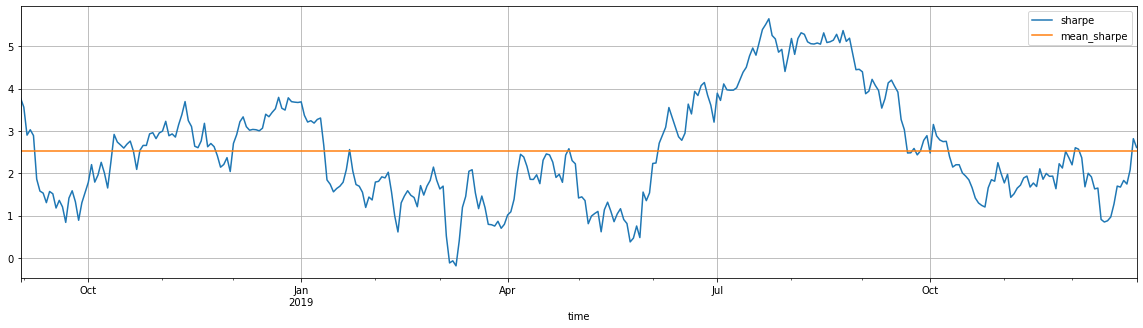

In [30]:
plot_rolling_sharpe(returns.total, 3)

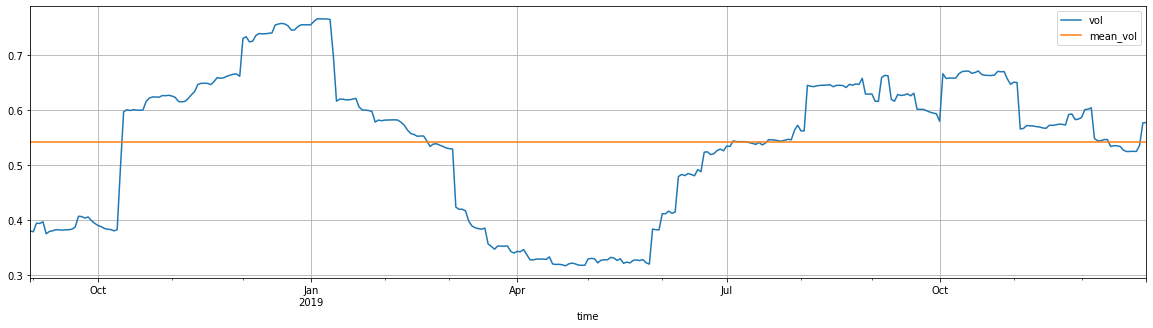

In [31]:
plot_rolling_vol(returns.total, 3)